# Creates all plots

In [16]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd

## Occupation old

In [17]:
main_df_oc_old = pd.read_pickle("lca_occupation_results_old.pkl")
print("Dataframe loaded!")

Dataframe loaded!


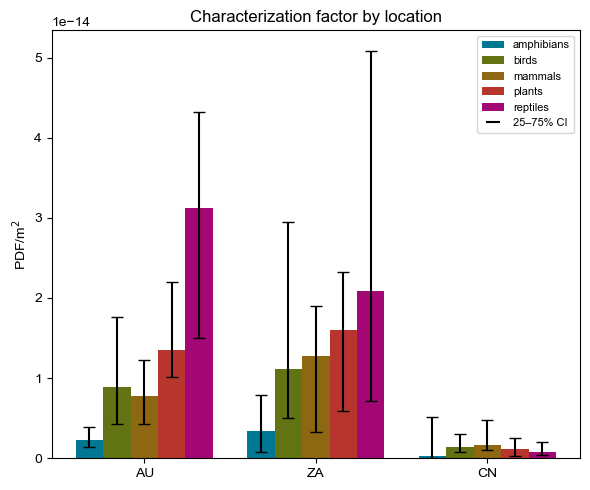

In [ ]:
# Countries AU, ZA, CN
custom_colors = ["#007894", "#627313", "#8e6713", "#b7352d", "#a30774"] 

# --- Style Settings ---
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'font.size': 10
})

cutoff = 0.00

# --- Legend Helper ---
errorbar_legend = Line2D(
    [0], [0], color='black', linestyle='none', marker='_',
    markersize=10, markeredgewidth=1.5, label='25–75% CI'
)

# --- Shared Data Prep ---
df_table = main_df_oc_old.copy()
m = df_table.loc[df_table["impact (mean)"] > 0, "impact (mean)"].max()
df = df_table[df_table["impact (mean)"].abs() > cutoff * m].copy()
df_net = df.copy()

# Flags
lower_percentile = "(25th)"
top_percentile = "(75th)"
has_cf_percentiles = f"CF {lower_percentile}" in df.columns and f"CF {top_percentile}" in df.columns

# Calculate Location Order (Standard Top 5)
d = df_net.groupby("consumer location").sum(numeric_only=True)
d = d.sort_values(by="amount", ascending=False)
loc_order = ['AU', 'ZA', 'CN']

# =========================================================
# PLOT B: Characterization factor by location
# =========================================================
fig, ax_b = plt.subplots(figsize=(6, 5)) 

df_b = main_df_oc_old.copy()

# Pick available CF columns
cf_cols = ["CF (mean)", f"CF {lower_percentile}", "CF (50th)", f"CF {top_percentile}"]
cf_cols = [c for c in cf_cols if c in df_b.columns]

# Aggregate
gb_b = (
    df_b
    .groupby(["consumer location", "method"])[cf_cols]
    .mean(numeric_only=True)
    .reset_index()
)

# Restrict to the customized loc_order
gb_b = gb_b[gb_b["consumer location"].isin(loc_order)]
gb_b["consumer location"] = pd.Categorical(gb_b["consumer location"], categories=loc_order, ordered=True)
gb_b = gb_b.sort_values(["consumer location", "method"])

methods_b = list(gb_b["method"].unique())
n_methods_b = max(1, len(methods_b))
x = np.arange(len(loc_order))
bar_width = min(0.8 / n_methods_b, 0.25)

b_dict = {m: gb_b[gb_b["method"] == m].set_index("consumer location") for m in methods_b}

for i, meth in enumerate(methods_b):
    # This .reindex(loc_order) ensures we try to grab 'AU' data specifically
    vals = b_dict[meth].reindex(loc_order)
    y = vals["CF (50th)"].values

    if has_cf_percentiles:
        lower = y - vals[f"CF {lower_percentile}"].values
        upper = vals[f"CF {top_percentile}"].values - y
        cf_errors = np.clip(np.vstack([lower, upper]), 0, None)
    else:
        cf_errors = None

    positions = x - (n_methods_b - 1) * bar_width / 2 + i * bar_width
    
    # Custom colors
    bar_color = custom_colors[i % len(custom_colors)]
    
    ax_b.bar(positions, y, yerr=cf_errors, capsize=4, width=bar_width, 
             label=str(meth), color=bar_color)

ax_b.set_title("Characterization factor by location")
ax_b.set_ylabel("PDF/m$^2$")
ax_b.set_xticks(x)
ax_b.set_xticklabels(loc_order, rotation=0)

# Legend
handles_b, labels_b = ax_b.get_legend_handles_labels()
handles_b.append(errorbar_legend)
labels_b.append('25–75% CI')
ax_b.legend(handles=handles_b, labels=labels_b, loc='upper right', fontsize=8)

plt.tight_layout()
plt.savefig("plots/occupation_CFs_by_location_old.png", dpi=150)
plt.show()

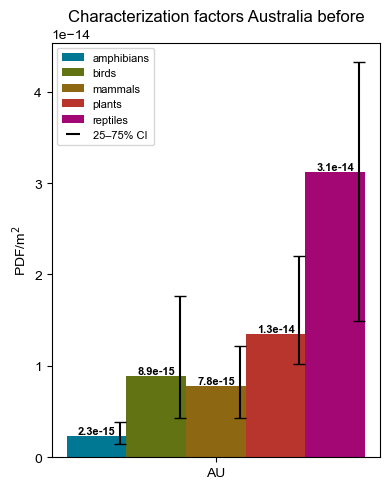

In [40]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd

# --- User Configuration ---
custom_colors = ["#007894", "#627313", "#8e6713", "#b7352d", "#a30774"] 

# --- Style Settings ---
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'font.size': 10
})

cutoff = 0.00

# --- Legend Helper ---
errorbar_legend = Line2D(
    [0], [0], color='black', linestyle='none', marker='_',
    markersize=10, markeredgewidth=1.5, label='25–75% CI'
)

# --- Shared Data Prep ---
df_table = main_df_oc_old.copy()
m = df_table.loc[df_table["impact (mean)"] > 0, "impact (mean)"].max()
df = df_table[df_table["impact (mean)"].abs() > cutoff * m].copy()
df_net = df.copy()

# Flags
lower_percentile = "(25th)"
top_percentile = "(75th)"
has_cf_percentiles = f"CF {lower_percentile}" in df.columns and f"CF {top_percentile}" in df.columns

# --- CHANGE: Set Location Order to ONLY AU ---
loc_order = ['AU']

# =========================================================
# PLOT B: Characterization factor by location (AU Only)
# =========================================================
fig, ax_b = plt.subplots(figsize=(4, 5)) 

df_b = main_df_oc_old.copy()

# Pick available CF columns
cf_cols = ["CF (mean)", f"CF {lower_percentile}", "CF (50th)", f"CF {top_percentile}"]
cf_cols = [c for c in cf_cols if c in df_b.columns]

# Aggregate
gb_b = (
    df_b
    .groupby(["consumer location", "method"])[cf_cols]
    .mean(numeric_only=True)
    .reset_index()
)

gb_b = gb_b[gb_b["consumer location"].isin(loc_order)]
gb_b["consumer location"] = pd.Categorical(gb_b["consumer location"], categories=loc_order, ordered=True)
gb_b = gb_b.sort_values(["consumer location", "method"])

methods_b = list(gb_b["method"].unique())
n_methods_b = max(1, len(methods_b))
x = np.arange(len(loc_order))
bar_width = min(0.8 / n_methods_b, 0.25)

b_dict = {m: gb_b[gb_b["method"] == m].set_index("consumer location") for m in methods_b}

for i, meth in enumerate(methods_b):
    vals = b_dict[meth].reindex(loc_order)
    y = vals["CF (50th)"].values

    if has_cf_percentiles:
        lower = y - vals[f"CF {lower_percentile}"].values
        upper = vals[f"CF {top_percentile}"].values - y
        cf_errors = np.clip(np.vstack([lower, upper]), 0, None)
    else:
        cf_errors = None

    positions = x - (n_methods_b - 1) * bar_width / 2 + i * bar_width
    
    # Custom colors
    bar_color = custom_colors[i % len(custom_colors)]
    
    # 1. Plot the MAIN BAR (No error bars here)
    bars = ax_b.bar(positions, y, width=bar_width, 
             label=str(meth), color=bar_color)

    # 2. Plot the ERROR BAR manually at the right edge
    if has_cf_percentiles:
        # Calculate X position: Center + Half Width = Right Edge
        error_x = positions + (bar_width / 2.5)
        
        ax_b.errorbar(error_x, y, yerr=cf_errors, 
                      fmt='none',       # 'none' means don't plot a marker point
                      ecolor='black',   # Color of the error line
                      elinewidth=1.5,   # Thickness of line
                      capsize=4)        # Width of the horizontal caps

    # 3. Add Labels (Centered on the bar)
    for bar, val in zip(bars, y):
        if pd.isna(val): continue
        y_pos = bar.get_height()
        ax_b.text(
            bar.get_x() + bar.get_width() / 2,  
            y_pos,                              
            f"{val:.1e}",                       
            ha='center', va='bottom', fontsize=8, color='black', fontweight='bold'
        )

ax_b.set_title("Characterization factors Australia before")
ax_b.set_ylabel("PDF/m$^2$")
ax_b.set_xticks(x)
ax_b.set_xticklabels(loc_order, rotation=0)

# Legend
handles_b, labels_b = ax_b.get_legend_handles_labels()
handles_b.append(errorbar_legend)
labels_b.append('25–75% CI')
ax_b.legend(handles=handles_b, labels=labels_b, loc='upper left', fontsize=8)

plt.tight_layout()
plt.savefig("plots/occupation_CFs_by_location_AU_old.png", dpi=150)
plt.show()

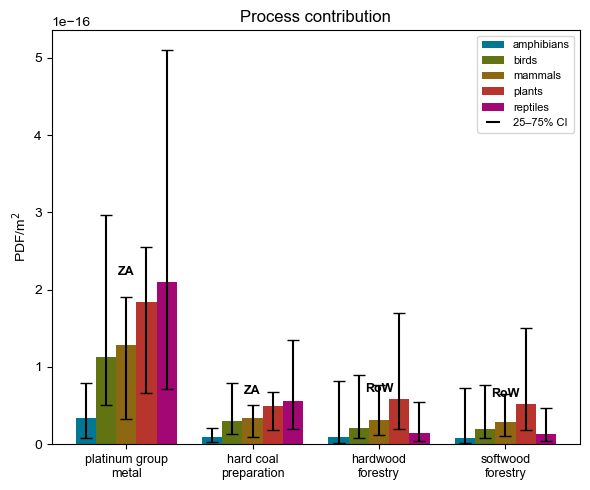

In [19]:
# --- User Configuration ---
# REPLACE THESE WITH YOUR EXACT HEX CODES
# Ensure you have as many colors as you have methods
custom_colors = ["#007894", "#627313", "#8e6713", "#b7352d", "#a30774"]

# --- Style Settings ---
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'font.size': 10
})

# --- Legend Helper ---
errorbar_legend = Line2D(
    [0], [0], color='black', linestyle='none', marker='_',
    markersize=10, markeredgewidth=1.5, label='25–75% CI'
)

# =========================================================
# PLOT C: Process contribution
# =========================================================
fig, ax_c = plt.subplots(figsize=(6, 5))

# --- Data Prep ---
df_c = main_df_oc_old.copy()
df_c["consumer name"] = df_c["consumer name"].str.split(", ").str[0]
df_c["label"] = df_c["consumer name"] + " (" + df_c["consumer location"] + ")"

# Flags
lower_percentile = "(25th)"
top_percentile = "(75th)"
has_imp_percentiles = f"impact {lower_percentile}" in df_c.columns and f"impact {top_percentile}" in df_c.columns

# Select top 4 labels by total mean impact
top_labels = (df_c.groupby("label", as_index=False)["impact (50th)"]
                .sum(numeric_only=True)
                .sort_values("impact (50th)", ascending=False)
                .head(4)["label"]
                .tolist())

# Aggregation dict
agg_c = {"impact (50th)": "sum"}
if has_imp_percentiles:
    agg_c[f"impact {lower_percentile}"] = "sum"
    agg_c[f"impact {top_percentile}"] = "sum"

# Group and aggregate
gb_c = (df_c[df_c["label"].isin(top_labels)]
        .groupby(["label", "method"])
        .agg(agg_c)
        .reset_index())

gb_c["label"] = pd.Categorical(gb_c["label"], categories=top_labels, ordered=True)
gb_c = gb_c.sort_values(["label", "method"])

methods_c = list(gb_c["method"].unique())
n_methods_c = max(1, len(methods_c))
x_c = np.arange(len(top_labels))
bar_width_c = min(0.8 / n_methods_c, 0.25)

# Per-method lookup
c_dict = {m: gb_c[gb_c["method"] == m].set_index("label") for m in methods_c}

# --- Plotting Loop ---
for i, meth in enumerate(methods_c):
    vals = c_dict[meth].reindex(top_labels)
    y = vals["impact (50th)"].values

    if has_imp_percentiles:
        err_lower = y - vals.get(f"impact {lower_percentile}", pd.Series(index=vals.index, dtype=float)).values
        err_upper = vals.get(f"impact {top_percentile}", pd.Series(index=vals.index, dtype=float)).values - y
        errors = np.clip(np.vstack([err_lower, err_upper]), 0, None)
    else:
        errors = None

    positions = x_c - (n_methods_c - 1) * bar_width_c / 2 + i * bar_width_c
    
    # --- COLOR SELECTION LOGIC ---
    bar_color = custom_colors[i % len(custom_colors)]

    ax_c.bar(positions, y, yerr=errors, capsize=4, width=bar_width_c, 
             label=str(meth), color=bar_color)

# --- Formatting ---
short_labels = pd.Series(top_labels).str.replace(r" \(([^)]+)\)$", "", regex=True)
countries = pd.Series(top_labels).str.extract(r"\(([^)]+)\)$")[0]
short_labels = [lbl.rsplit(" ", 1)[0] + "\n" + lbl.rsplit(" ", 1)[1] if " " in lbl else lbl
                for lbl in short_labels]
short_labels = [lbl.replace("deionized", "").replace("gravel and sand ", "") for lbl in short_labels]

ax_c.set_xticks(x_c)
ax_c.set_xticklabels(short_labels, rotation=0, ha="center", size=9)
ax_c.set_title("Process contribution")
ax_c.set_ylabel("PDF/m$^2$")

# Annotate Country Codes
cluster_tops = []
for j in range(len(x_c)):
    ys = []
    for meth in methods_c:
        vals = c_dict[meth].reindex(top_labels)
        ys.append(vals["impact (50th)"].values[j] if j < len(vals) else np.nan)
    cluster_tops.append(np.nanmax(ys))

for xi, yi, code in zip(x_c, cluster_tops, countries):
    if pd.notna(yi):
        ax_c.annotate(code, (xi, yi), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=9, fontweight='bold')

# Legend
handles_c, labels_c = ax_c.get_legend_handles_labels()
handles_c.append(errorbar_legend)
labels_c.append('25–75% CI')
ax_c.legend(handles=handles_c, labels=labels_c, loc='upper right', fontsize=8)

plt.tight_layout()
plt.savefig("plots/occupation_CFs_by_process_old.png", dpi=150)
#plt.show()

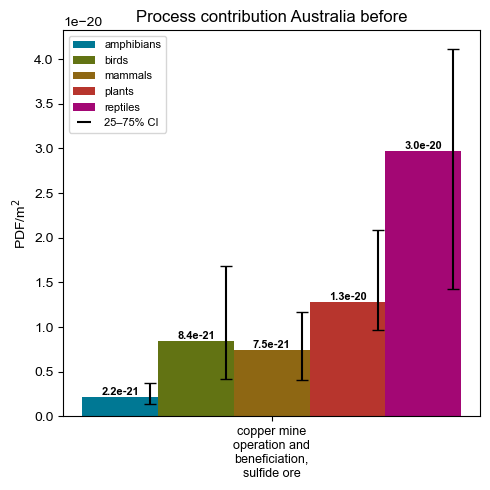

In [58]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import textwrap

# --- User Configuration ---
custom_colors = ["#007894", "#627313", "#8e6713", "#b7352d", "#a30774"]

# --- Style Settings ---
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'font.size': 10
})

# --- Legend Helper ---
errorbar_legend = Line2D(
    [0], [0], color='black', linestyle='none', marker='_',
    markersize=10, markeredgewidth=1.5, label='25–75% CI'
)

# =========================================================
# PLOT C: Process contribution (Specific AU Processes)
# =========================================================
# Reduced width slightly since it's likely a single group
fig, ax_c = plt.subplots(figsize=(5, 5))

# --- Data Prep ---
df_c = main_df_oc_old.copy()

# 1. Filter for Australia
df_c = df_c[df_c["consumer location"] == "AU"].copy()

# 2. Define the EXACT target processes
target_processes = [
    'copper mine operation and beneficiation, sulfide ore'
]

# 3. Filter
df_c = df_c[df_c["consumer name"].isin(target_processes)]

# 4. Create label column
df_c["plot_label"] = df_c["consumer name"]

# Flags for error bars
lower_percentile = "(25th)"
top_percentile = "(75th)"
has_imp_percentiles = f"impact {lower_percentile}" in df_c.columns and f"impact {top_percentile}" in df_c.columns

# Sort order
top_labels = [t for t in target_processes if t in df_c["plot_label"].unique()]

if not top_labels:
    print("WARNING: No data found for these processes in AU. Check exact spelling.")

# Aggregation
agg_c = {"impact (50th)": "sum"}
if has_imp_percentiles:
    agg_c[f"impact {lower_percentile}"] = "sum"
    agg_c[f"impact {top_percentile}"] = "sum"

# Group
gb_c = (df_c
        .groupby(["plot_label", "method"])
        .agg(agg_c)
        .reset_index())

gb_c["plot_label"] = pd.Categorical(gb_c["plot_label"], categories=top_labels, ordered=True)
gb_c = gb_c.sort_values(["plot_label", "method"])

methods_c = list(gb_c["method"].unique())
n_methods_c = max(1, len(methods_c))
x_c = np.arange(len(top_labels))
bar_width_c = min(0.8 / n_methods_c, 0.25)

# Per-method lookup
c_dict = {m: gb_c[gb_c["method"] == m].set_index("plot_label") for m in methods_c}

# --- Plotting Loop ---
for i, meth in enumerate(methods_c):
    vals = c_dict[meth].reindex(top_labels)
    y = vals["impact (50th)"].values

    if has_imp_percentiles:
        val_lower = vals.get(f"impact {lower_percentile}", pd.Series(index=vals.index, dtype=float)).values
        val_upper = vals.get(f"impact {top_percentile}", pd.Series(index=vals.index, dtype=float)).values
        
        y = np.nan_to_num(y)
        val_lower = np.nan_to_num(val_lower)
        val_upper = np.nan_to_num(val_upper)
        
        err_lower = y - val_lower
        err_upper = val_upper - y
        errors = np.clip(np.vstack([err_lower, err_upper]), 0, None)
    else:
        errors = None

    positions = x_c - (n_methods_c - 1) * bar_width_c / 2 + i * bar_width_c
    bar_color = custom_colors[i % len(custom_colors)]

    # 1. Plot MAIN BAR (no yerr here)
    bars = ax_c.bar(positions, y, width=bar_width_c, 
             label=str(meth), color=bar_color)
    
    # 2. Plot ERROR BAR at the right edge
    if has_imp_percentiles:
        # X position = Center + Half Width
        error_x = positions + (bar_width_c / 2.5)
        
        ax_c.errorbar(error_x, y, yerr=errors, 
                      fmt='none', ecolor='black', elinewidth=1.5, capsize=4)

    # 3. Add TEXT LABELS on top of the bar
    for bar, val in zip(bars, y):
        if pd.isna(val): continue
        
        # Place text at bar height
        y_pos = bar.get_height()
        
        ax_c.text(
            bar.get_x() + bar.get_width() / 2,  # Center X
            y_pos,                              # Top Y
            f"{val:.1e}",                       # Scientific notation
            ha='center', va='bottom',           # Bottom align so it sits ON the bar
            fontsize=8, color='black', fontweight='bold'
        )

# --- Formatting ---
wrapped_labels = [textwrap.fill(lbl, 20) for lbl in top_labels]

ax_c.set_xticks(x_c)
ax_c.set_xticklabels(wrapped_labels, rotation=0, ha="center", size=9)
ax_c.set_title("Process contribution Australia before")
ax_c.set_ylabel("PDF/m$^2$")

# Legend
handles_c, labels_c = ax_c.get_legend_handles_labels()
handles_c.append(errorbar_legend)
labels_c.append('25–75% CI')
ax_c.legend(handles=handles_c, labels=labels_c, loc='upper left', fontsize=8)

plt.tight_layout()
plt.savefig("plots/occupation_CFs_by_process_AU_copper_old.png", dpi=150)
plt.show()

## Occupation new

In [20]:
main_df_oc_new = pd.read_pickle("lca_occupation_results_new.pkl")
print("Dataframe loaded!")

Dataframe loaded!


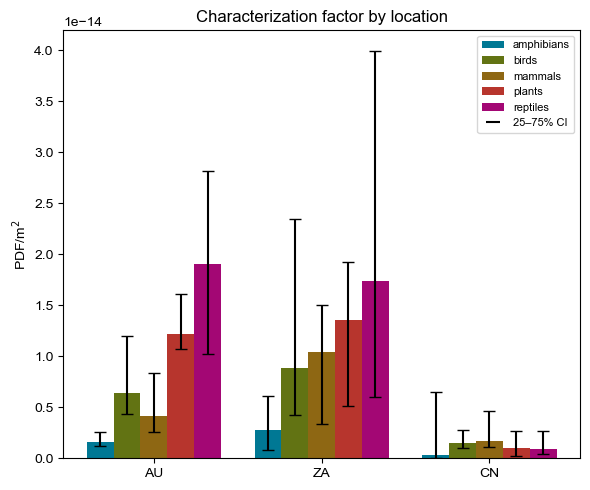

In [21]:
# --- User Configuration ---
custom_colors = ["#007894", "#627313", "#8e6713", "#b7352d", "#a30774"] 

# --- Style Settings ---
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'font.size': 10
})

cutoff = 0.00

# --- Legend Helper ---
errorbar_legend = Line2D(
    [0], [0], color='black', linestyle='none', marker='_',
    markersize=10, markeredgewidth=1.5, label='25–75% CI'
)

# --- Shared Data Prep ---
df_table = main_df_oc_new.copy()
m = df_table.loc[df_table["impact (mean)"] > 0, "impact (mean)"].max()
df = df_table[df_table["impact (mean)"].abs() > cutoff * m].copy()
df_net = df.copy()

# Flags
lower_percentile = "(25th)"
top_percentile = "(75th)"
has_cf_percentiles = f"CF {lower_percentile}" in df.columns and f"CF {top_percentile}" in df.columns

# Calculate Location Order (Standard Top 5)
d = df_net.groupby("consumer location").sum(numeric_only=True)
d = d.sort_values(by="amount", ascending=False)
loc_order = ['AU', 'ZA', 'CN']

# =========================================================
# PLOT B: Characterization factor by location
# =========================================================
fig, ax_b = plt.subplots(figsize=(6, 5)) 

df_b = main_df_oc_new.copy()

# Pick available CF columns
cf_cols = ["CF (mean)", f"CF {lower_percentile}", "CF (50th)", f"CF {top_percentile}"]
cf_cols = [c for c in cf_cols if c in df_b.columns]

# Aggregate
gb_b = (
    df_b
    .groupby(["consumer location", "method"])[cf_cols]
    .mean(numeric_only=True)
    .reset_index()
)

# Restrict to the customized loc_order
gb_b = gb_b[gb_b["consumer location"].isin(loc_order)]
gb_b["consumer location"] = pd.Categorical(gb_b["consumer location"], categories=loc_order, ordered=True)
gb_b = gb_b.sort_values(["consumer location", "method"])

methods_b = list(gb_b["method"].unique())
n_methods_b = max(1, len(methods_b))
x = np.arange(len(loc_order))
bar_width = min(0.8 / n_methods_b, 0.25)

b_dict = {m: gb_b[gb_b["method"] == m].set_index("consumer location") for m in methods_b}

for i, meth in enumerate(methods_b):
    # This .reindex(loc_order) ensures we try to grab 'AU' data specifically
    vals = b_dict[meth].reindex(loc_order)
    y = vals["CF (50th)"].values

    if has_cf_percentiles:
        lower = y - vals[f"CF {lower_percentile}"].values
        upper = vals[f"CF {top_percentile}"].values - y
        cf_errors = np.clip(np.vstack([lower, upper]), 0, None)
    else:
        cf_errors = None

    positions = x - (n_methods_b - 1) * bar_width / 2 + i * bar_width
    
    # Custom colors
    bar_color = custom_colors[i % len(custom_colors)]
    
    ax_b.bar(positions, y, yerr=cf_errors, capsize=4, width=bar_width, 
             label=str(meth), color=bar_color)

ax_b.set_title("Characterization factor by location")
ax_b.set_ylabel("PDF/m$^2$")
ax_b.set_xticks(x)
ax_b.set_xticklabels(loc_order, rotation=0)

# Legend
handles_b, labels_b = ax_b.get_legend_handles_labels()
handles_b.append(errorbar_legend)
labels_b.append('25–75% CI')
ax_b.legend(handles=handles_b, labels=labels_b, loc='upper right', fontsize=8)

plt.tight_layout()
plt.savefig("plots/occupation_CFs_by_location_new.png", dpi=150)
plt.show()

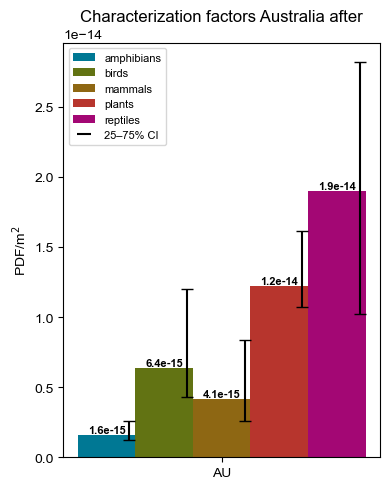

In [41]:
### only AU ###
custom_colors = ["#007894", "#627313", "#8e6713", "#b7352d", "#a30774"] 

# --- Style Settings ---
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'font.size': 10
})

cutoff = 0.00

# --- Legend Helper ---
errorbar_legend = Line2D(
    [0], [0], color='black', linestyle='none', marker='_',
    markersize=10, markeredgewidth=1.5, label='25–75% CI'
)

# --- Shared Data Prep ---
df_table = main_df_oc_new.copy()
m = df_table.loc[df_table["impact (mean)"] > 0, "impact (mean)"].max()
df = df_table[df_table["impact (mean)"].abs() > cutoff * m].copy()
df_net = df.copy()

# Flags
lower_percentile = "(25th)"
top_percentile = "(75th)"
has_cf_percentiles = f"CF {lower_percentile}" in df.columns and f"CF {top_percentile}" in df.columns

# --- CHANGE: Set Location Order to ONLY AU ---
loc_order = ['AU']

# =========================================================
# PLOT B: Characterization factor by location (AU Only)
# =========================================================
fig, ax_b = plt.subplots(figsize=(4, 5)) 

df_b = main_df_oc_new.copy()

# Pick available CF columns
cf_cols = ["CF (mean)", f"CF {lower_percentile}", "CF (50th)", f"CF {top_percentile}"]
cf_cols = [c for c in cf_cols if c in df_b.columns]

# Aggregate
gb_b = (
    df_b
    .groupby(["consumer location", "method"])[cf_cols]
    .mean(numeric_only=True)
    .reset_index()
)

gb_b = gb_b[gb_b["consumer location"].isin(loc_order)]
gb_b["consumer location"] = pd.Categorical(gb_b["consumer location"], categories=loc_order, ordered=True)
gb_b = gb_b.sort_values(["consumer location", "method"])

methods_b = list(gb_b["method"].unique())
n_methods_b = max(1, len(methods_b))
x = np.arange(len(loc_order))
bar_width = min(0.8 / n_methods_b, 0.25)

b_dict = {m: gb_b[gb_b["method"] == m].set_index("consumer location") for m in methods_b}

for i, meth in enumerate(methods_b):
    vals = b_dict[meth].reindex(loc_order)
    y = vals["CF (50th)"].values

    if has_cf_percentiles:
        lower = y - vals[f"CF {lower_percentile}"].values
        upper = vals[f"CF {top_percentile}"].values - y
        cf_errors = np.clip(np.vstack([lower, upper]), 0, None)
    else:
        cf_errors = None

    positions = x - (n_methods_b - 1) * bar_width / 2 + i * bar_width
    
    # Custom colors
    bar_color = custom_colors[i % len(custom_colors)]
    
    # 1. Plot the MAIN BAR (No error bars here)
    bars = ax_b.bar(positions, y, width=bar_width, 
             label=str(meth), color=bar_color)

    # 2. Plot the ERROR BAR manually at the right edge
    if has_cf_percentiles:
        # Calculate X position: Center + Half Width = Right Edge
        error_x = positions + (bar_width / 2.5)
        
        ax_b.errorbar(error_x, y, yerr=cf_errors, 
                      fmt='none',       # 'none' means don't plot a marker point
                      ecolor='black',   # Color of the error line
                      elinewidth=1.5,   # Thickness of line
                      capsize=4)        # Width of the horizontal caps

    # 3. Add Labels (Centered on the bar)
    for bar, val in zip(bars, y):
        if pd.isna(val): continue
        y_pos = bar.get_height()
        ax_b.text(
            bar.get_x() + bar.get_width() / 2,  
            y_pos,                              
            f"{val:.1e}",                       
            ha='center', va='bottom', fontsize=8, color='black', fontweight='bold'
        )

ax_b.set_title("Characterization factors Australia after")
ax_b.set_ylabel("PDF/m$^2$")
ax_b.set_xticks(x)
ax_b.set_xticklabels(loc_order, rotation=0)

# Legend
handles_b, labels_b = ax_b.get_legend_handles_labels()
handles_b.append(errorbar_legend)
labels_b.append('25–75% CI')
ax_b.legend(handles=handles_b, labels=labels_b, loc='upper left', fontsize=8)

plt.tight_layout()
plt.savefig("plots/occupation_CFs_by_location_AU_new.png", dpi=150)
plt.show()

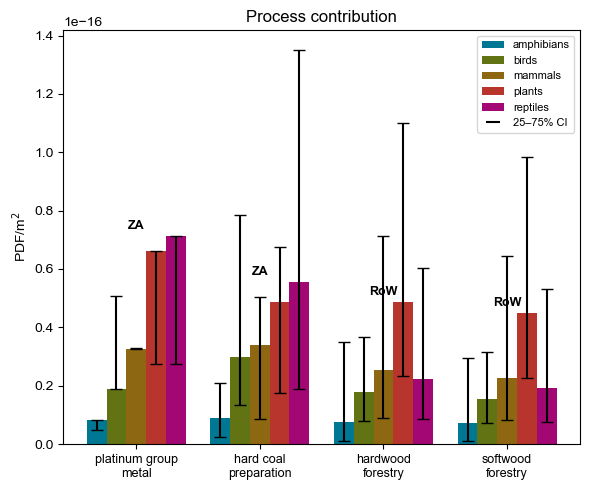

In [22]:
# --- User Configuration ---
# REPLACE THESE WITH YOUR EXACT HEX CODES
# Ensure you have as many colors as you have methods
custom_colors = ["#007894", "#627313", "#8e6713", "#b7352d", "#a30774"]

# --- Style Settings ---
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'font.size': 10
})

# --- Legend Helper ---
errorbar_legend = Line2D(
    [0], [0], color='black', linestyle='none', marker='_',
    markersize=10, markeredgewidth=1.5, label='25–75% CI'
)

# =========================================================
# PLOT C: Process contribution
# =========================================================
fig, ax_c = plt.subplots(figsize=(6, 5))

# --- Data Prep ---
df_c = main_df_oc_new.copy()
df_c["consumer name"] = df_c["consumer name"].str.split(", ").str[0]
df_c["label"] = df_c["consumer name"] + " (" + df_c["consumer location"] + ")"

# Flags
lower_percentile = "(25th)"
top_percentile = "(75th)"
has_imp_percentiles = f"impact {lower_percentile}" in df_c.columns and f"impact {top_percentile}" in df_c.columns

# Select top 4 labels by total mean impact
top_labels = (df_c.groupby("label", as_index=False)["impact (50th)"]
                .sum(numeric_only=True)
                .sort_values("impact (50th)", ascending=False)
                .head(4)["label"]
                .tolist())

# Aggregation dict
agg_c = {"impact (50th)": "sum"}
if has_imp_percentiles:
    agg_c[f"impact {lower_percentile}"] = "sum"
    agg_c[f"impact {top_percentile}"] = "sum"

# Group and aggregate
gb_c = (df_c[df_c["label"].isin(top_labels)]
        .groupby(["label", "method"])
        .agg(agg_c)
        .reset_index())

gb_c["label"] = pd.Categorical(gb_c["label"], categories=top_labels, ordered=True)
gb_c = gb_c.sort_values(["label", "method"])

methods_c = list(gb_c["method"].unique())
n_methods_c = max(1, len(methods_c))
x_c = np.arange(len(top_labels))
bar_width_c = min(0.8 / n_methods_c, 0.25)

# Per-method lookup
c_dict = {m: gb_c[gb_c["method"] == m].set_index("label") for m in methods_c}

# --- Plotting Loop ---
for i, meth in enumerate(methods_c):
    vals = c_dict[meth].reindex(top_labels)
    y = vals["impact (50th)"].values

    if has_imp_percentiles:
        err_lower = y - vals.get(f"impact {lower_percentile}", pd.Series(index=vals.index, dtype=float)).values
        err_upper = vals.get(f"impact {top_percentile}", pd.Series(index=vals.index, dtype=float)).values - y
        errors = np.clip(np.vstack([err_lower, err_upper]), 0, None)
    else:
        errors = None

    positions = x_c - (n_methods_c - 1) * bar_width_c / 2 + i * bar_width_c
    
    # --- COLOR SELECTION LOGIC ---
    bar_color = custom_colors[i % len(custom_colors)]

    ax_c.bar(positions, y, yerr=errors, capsize=4, width=bar_width_c, 
             label=str(meth), color=bar_color)

# --- Formatting ---
short_labels = pd.Series(top_labels).str.replace(r" \(([^)]+)\)$", "", regex=True)
countries = pd.Series(top_labels).str.extract(r"\(([^)]+)\)$")[0]
short_labels = [lbl.rsplit(" ", 1)[0] + "\n" + lbl.rsplit(" ", 1)[1] if " " in lbl else lbl
                for lbl in short_labels]
short_labels = [lbl.replace("deionized", "").replace("gravel and sand ", "") for lbl in short_labels]

ax_c.set_xticks(x_c)
ax_c.set_xticklabels(short_labels, rotation=0, ha="center", size=9)
ax_c.set_title("Process contribution")
ax_c.set_ylabel("PDF/m$^2$")

# Annotate Country Codes
cluster_tops = []
for j in range(len(x_c)):
    ys = []
    for meth in methods_c:
        vals = c_dict[meth].reindex(top_labels)
        ys.append(vals["impact (50th)"].values[j] if j < len(vals) else np.nan)
    cluster_tops.append(np.nanmax(ys))

for xi, yi, code in zip(x_c, cluster_tops, countries):
    if pd.notna(yi):
        ax_c.annotate(code, (xi, yi), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=9, fontweight='bold')

# Legend
handles_c, labels_c = ax_c.get_legend_handles_labels()
handles_c.append(errorbar_legend)
labels_c.append('25–75% CI')
ax_c.legend(handles=handles_c, labels=labels_c, loc='upper right', fontsize=8)

plt.tight_layout()
plt.savefig("plots/occupation_CFs_by_process_new.png", dpi=150)
plt.show()

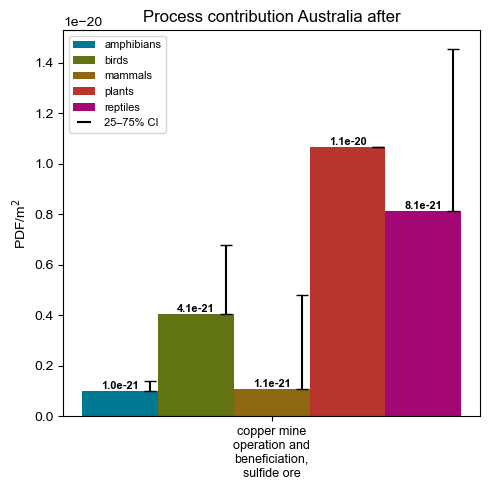

In [59]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import textwrap

# --- User Configuration ---
custom_colors = ["#007894", "#627313", "#8e6713", "#b7352d", "#a30774"]

# --- Style Settings ---
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'font.size': 10
})

# --- Legend Helper ---
errorbar_legend = Line2D(
    [0], [0], color='black', linestyle='none', marker='_',
    markersize=10, markeredgewidth=1.5, label='25–75% CI'
)

# =========================================================
# PLOT C: Process contribution (Specific AU Processes)
# =========================================================
# Reduced width slightly since it's likely a single group
fig, ax_c = plt.subplots(figsize=(5, 5))

# --- Data Prep ---
df_c = main_df_oc_new.copy()

# 1. Filter for Australia
df_c = df_c[df_c["consumer location"] == "AU"].copy()

# 2. Define the EXACT target processes
target_processes = [
    'copper mine operation and beneficiation, sulfide ore'
]

# 3. Filter
df_c = df_c[df_c["consumer name"].isin(target_processes)]

# 4. Create label column
df_c["plot_label"] = df_c["consumer name"]

# Flags for error bars
lower_percentile = "(25th)"
top_percentile = "(75th)"
has_imp_percentiles = f"impact {lower_percentile}" in df_c.columns and f"impact {top_percentile}" in df_c.columns

# Sort order
top_labels = [t for t in target_processes if t in df_c["plot_label"].unique()]

if not top_labels:
    print("WARNING: No data found for these processes in AU. Check exact spelling.")

# Aggregation
agg_c = {"impact (50th)": "sum"}
if has_imp_percentiles:
    agg_c[f"impact {lower_percentile}"] = "sum"
    agg_c[f"impact {top_percentile}"] = "sum"

# Group
gb_c = (df_c
        .groupby(["plot_label", "method"])
        .agg(agg_c)
        .reset_index())

gb_c["plot_label"] = pd.Categorical(gb_c["plot_label"], categories=top_labels, ordered=True)
gb_c = gb_c.sort_values(["plot_label", "method"])

methods_c = list(gb_c["method"].unique())
n_methods_c = max(1, len(methods_c))
x_c = np.arange(len(top_labels))
bar_width_c = min(0.8 / n_methods_c, 0.25)

# Per-method lookup
c_dict = {m: gb_c[gb_c["method"] == m].set_index("plot_label") for m in methods_c}

# --- Plotting Loop ---
for i, meth in enumerate(methods_c):
    vals = c_dict[meth].reindex(top_labels)
    y = vals["impact (50th)"].values

    if has_imp_percentiles:
        val_lower = vals.get(f"impact {lower_percentile}", pd.Series(index=vals.index, dtype=float)).values
        val_upper = vals.get(f"impact {top_percentile}", pd.Series(index=vals.index, dtype=float)).values
        
        y = np.nan_to_num(y)
        val_lower = np.nan_to_num(val_lower)
        val_upper = np.nan_to_num(val_upper)
        
        err_lower = y - val_lower
        err_upper = val_upper - y
        errors = np.clip(np.vstack([err_lower, err_upper]), 0, None)
    else:
        errors = None

    positions = x_c - (n_methods_c - 1) * bar_width_c / 2 + i * bar_width_c
    bar_color = custom_colors[i % len(custom_colors)]

    # 1. Plot MAIN BAR (no yerr here)
    bars = ax_c.bar(positions, y, width=bar_width_c, 
             label=str(meth), color=bar_color)
    
    # 2. Plot ERROR BAR at the right edge
    if has_imp_percentiles:
        # X position = Center + Half Width
        error_x = positions + (bar_width_c / 2.5)
        
        ax_c.errorbar(error_x, y, yerr=errors, 
                      fmt='none', ecolor='black', elinewidth=1.5, capsize=4)

    # 3. Add TEXT LABELS on top of the bar
    for bar, val in zip(bars, y):
        if pd.isna(val): continue
        
        # Place text at bar height
        y_pos = bar.get_height()
        
        ax_c.text(
            bar.get_x() + bar.get_width() / 2,  # Center X
            y_pos,                              # Top Y
            f"{val:.1e}",                       # Scientific notation
            ha='center', va='bottom',           # Bottom align so it sits ON the bar
            fontsize=8, color='black', fontweight='bold'
        )

# --- Formatting ---
wrapped_labels = [textwrap.fill(lbl, 20) for lbl in top_labels]

ax_c.set_xticks(x_c)
ax_c.set_xticklabels(wrapped_labels, rotation=0, ha="center", size=9)
ax_c.set_title("Process contribution Australia after")
ax_c.set_ylabel("PDF/m$^2$")

# Legend
handles_c, labels_c = ax_c.get_legend_handles_labels()
handles_c.append(errorbar_legend)
labels_c.append('25–75% CI')
ax_c.legend(handles=handles_c, labels=labels_c, loc='upper left', fontsize=8)

plt.tight_layout()
plt.savefig("plots/occupation_CFs_by_process_AU_copper_new.png", dpi=150)
plt.show()

## Transformation old

In [23]:
main_df_tra_old = pd.read_pickle("lca_transformation_results_old.pkl")
print("Dataframe loaded!")

Dataframe loaded!


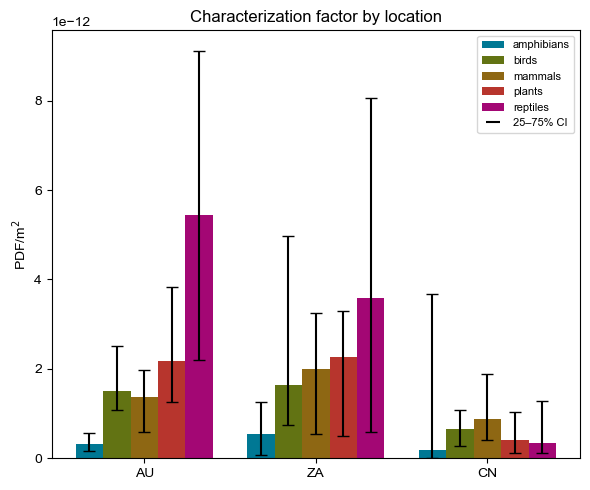

In [24]:
# --- User Configuration ---
custom_colors = ["#007894", "#627313", "#8e6713", "#b7352d", "#a30774"] 

# --- Style Settings ---
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'font.size': 10
})

cutoff = 0.00

# --- Legend Helper ---
errorbar_legend = Line2D(
    [0], [0], color='black', linestyle='none', marker='_',
    markersize=10, markeredgewidth=1.5, label='25–75% CI'
)

# --- Shared Data Prep ---
df_table = main_df_tra_old.copy()
m = df_table.loc[df_table["impact (mean)"] > 0, "impact (mean)"].max()
df = df_table[df_table["impact (mean)"].abs() > cutoff * m].copy()
df_net = df.copy()

# Flags
lower_percentile = "(25th)"
top_percentile = "(75th)"
has_cf_percentiles = f"CF {lower_percentile}" in df.columns and f"CF {top_percentile}" in df.columns

# Calculate Location Order (Standard Top 5)
d = df_net.groupby("consumer location").sum(numeric_only=True)
d = d.sort_values(by="amount", ascending=False)
loc_order = ['AU', 'ZA', 'CN']

# =========================================================
# PLOT B: Characterization factor by location
# =========================================================
fig, ax_b = plt.subplots(figsize=(6, 5)) 

df_b = main_df_tra_old.copy()

# Pick available CF columns
cf_cols = ["CF (mean)", f"CF {lower_percentile}", "CF (50th)", f"CF {top_percentile}"]
cf_cols = [c for c in cf_cols if c in df_b.columns]

# Aggregate
gb_b = (
    df_b
    .groupby(["consumer location", "method"])[cf_cols]
    .mean(numeric_only=True)
    .reset_index()
)

# Restrict to the customized loc_order
gb_b = gb_b[gb_b["consumer location"].isin(loc_order)]
gb_b["consumer location"] = pd.Categorical(gb_b["consumer location"], categories=loc_order, ordered=True)
gb_b = gb_b.sort_values(["consumer location", "method"])

methods_b = list(gb_b["method"].unique())
n_methods_b = max(1, len(methods_b))
x = np.arange(len(loc_order))
bar_width = min(0.8 / n_methods_b, 0.25)

b_dict = {m: gb_b[gb_b["method"] == m].set_index("consumer location") for m in methods_b}

for i, meth in enumerate(methods_b):
    # This .reindex(loc_order) ensures we try to grab 'AU' data specifically
    vals = b_dict[meth].reindex(loc_order)
    y = vals["CF (50th)"].values

    if has_cf_percentiles:
        lower = y - vals[f"CF {lower_percentile}"].values
        upper = vals[f"CF {top_percentile}"].values - y
        cf_errors = np.clip(np.vstack([lower, upper]), 0, None)
    else:
        cf_errors = None

    positions = x - (n_methods_b - 1) * bar_width / 2 + i * bar_width
    
    # Custom colors
    bar_color = custom_colors[i % len(custom_colors)]
    
    ax_b.bar(positions, y, yerr=cf_errors, capsize=4, width=bar_width, 
             label=str(meth), color=bar_color)

ax_b.set_title("Characterization factor by location")
ax_b.set_ylabel("PDF/m$^2$")
ax_b.set_xticks(x)
ax_b.set_xticklabels(loc_order, rotation=0)

# Legend
handles_b, labels_b = ax_b.get_legend_handles_labels()
handles_b.append(errorbar_legend)
labels_b.append('25–75% CI')
ax_b.legend(handles=handles_b, labels=labels_b, loc='upper right', fontsize=8)

plt.tight_layout()
plt.savefig("plots/transformation_CFs_by_location_old.png", dpi=150)
plt.show()

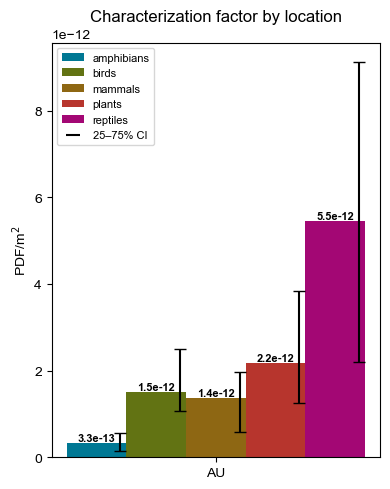

In [38]:
### only AU ###
custom_colors = ["#007894", "#627313", "#8e6713", "#b7352d", "#a30774"] 

# --- Style Settings ---
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'font.size': 10
})

cutoff = 0.00

# --- Legend Helper ---
errorbar_legend = Line2D(
    [0], [0], color='black', linestyle='none', marker='_',
    markersize=10, markeredgewidth=1.5, label='25–75% CI'
)

# --- Shared Data Prep ---
df_table = main_df_tra_old.copy()
m = df_table.loc[df_table["impact (mean)"] > 0, "impact (mean)"].max()
df = df_table[df_table["impact (mean)"].abs() > cutoff * m].copy()
df_net = df.copy()

# Flags
lower_percentile = "(25th)"
top_percentile = "(75th)"
has_cf_percentiles = f"CF {lower_percentile}" in df.columns and f"CF {top_percentile}" in df.columns

# --- CHANGE: Set Location Order to ONLY AU ---
loc_order = ['AU']

# =========================================================
# PLOT B: Characterization factor by location (AU Only)
# =========================================================
fig, ax_b = plt.subplots(figsize=(4, 5)) 

df_b = main_df_tra_old.copy()

# Pick available CF columns
cf_cols = ["CF (mean)", f"CF {lower_percentile}", "CF (50th)", f"CF {top_percentile}"]
cf_cols = [c for c in cf_cols if c in df_b.columns]

# Aggregate
gb_b = (
    df_b
    .groupby(["consumer location", "method"])[cf_cols]
    .mean(numeric_only=True)
    .reset_index()
)

gb_b = gb_b[gb_b["consumer location"].isin(loc_order)]
gb_b["consumer location"] = pd.Categorical(gb_b["consumer location"], categories=loc_order, ordered=True)
gb_b = gb_b.sort_values(["consumer location", "method"])

methods_b = list(gb_b["method"].unique())
n_methods_b = max(1, len(methods_b))
x = np.arange(len(loc_order))
bar_width = min(0.8 / n_methods_b, 0.25)

b_dict = {m: gb_b[gb_b["method"] == m].set_index("consumer location") for m in methods_b}

for i, meth in enumerate(methods_b):
    vals = b_dict[meth].reindex(loc_order)
    y = vals["CF (50th)"].values

    if has_cf_percentiles:
        lower = y - vals[f"CF {lower_percentile}"].values
        upper = vals[f"CF {top_percentile}"].values - y
        cf_errors = np.clip(np.vstack([lower, upper]), 0, None)
    else:
        cf_errors = None

    positions = x - (n_methods_b - 1) * bar_width / 2 + i * bar_width
    
    # Custom colors
    bar_color = custom_colors[i % len(custom_colors)]
    
    # 1. Plot the MAIN BAR (No error bars here)
    bars = ax_b.bar(positions, y, width=bar_width, 
             label=str(meth), color=bar_color)

    # 2. Plot the ERROR BAR manually at the right edge
    if has_cf_percentiles:
        # Calculate X position: Center + Half Width = Right Edge
        error_x = positions + (bar_width / 2.5)
        
        ax_b.errorbar(error_x, y, yerr=cf_errors, 
                      fmt='none',       # 'none' means don't plot a marker point
                      ecolor='black',   # Color of the error line
                      elinewidth=1.5,   # Thickness of line
                      capsize=4)        # Width of the horizontal caps

    # 3. Add Labels (Centered on the bar)
    for bar, val in zip(bars, y):
        if pd.isna(val): continue
        y_pos = bar.get_height()
        ax_b.text(
            bar.get_x() + bar.get_width() / 2,  
            y_pos,                              
            f"{val:.1e}",                       
            ha='center', va='bottom', fontsize=8, color='black', fontweight='bold'
        )

ax_b.set_title("Characterization factor by location")
ax_b.set_ylabel("PDF/m$^2$")
ax_b.set_xticks(x)
ax_b.set_xticklabels(loc_order, rotation=0)

# Legend
handles_b, labels_b = ax_b.get_legend_handles_labels()
handles_b.append(errorbar_legend)
labels_b.append('25–75% CI')
ax_b.legend(handles=handles_b, labels=labels_b, loc='upper left', fontsize=8)

plt.tight_layout()
plt.savefig("plots/transformation_CFs_by_location_AU_old.png", dpi=150)
plt.show()

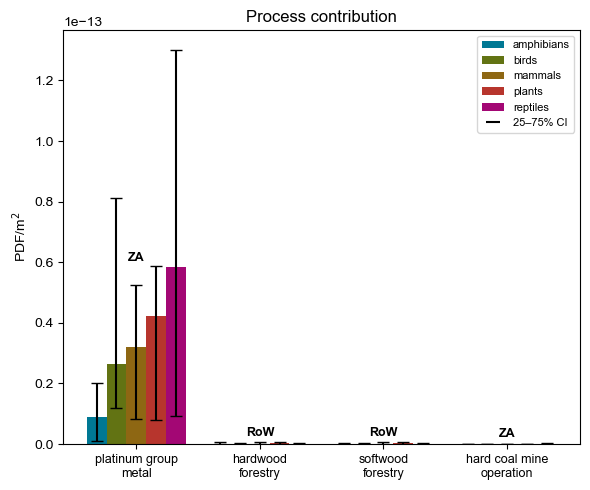

In [25]:
# --- User Configuration ---
# REPLACE THESE WITH YOUR EXACT HEX CODES
# Ensure you have as many colors as you have methods
custom_colors = ["#007894", "#627313", "#8e6713", "#b7352d", "#a30774"]

# --- Style Settings ---
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'font.size': 10
})

# --- Legend Helper ---
errorbar_legend = Line2D(
    [0], [0], color='black', linestyle='none', marker='_',
    markersize=10, markeredgewidth=1.5, label='25–75% CI'
)

# =========================================================
# PLOT C: Process contribution
# =========================================================
fig, ax_c = plt.subplots(figsize=(6, 5))

# --- Data Prep ---
df_c = main_df_tra_old.copy()
df_c["consumer name"] = df_c["consumer name"].str.split(", ").str[0]
df_c["label"] = df_c["consumer name"] + " (" + df_c["consumer location"] + ")"

# Flags
lower_percentile = "(25th)"
top_percentile = "(75th)"
has_imp_percentiles = f"impact {lower_percentile}" in df_c.columns and f"impact {top_percentile}" in df_c.columns

# Select top 4 labels by total mean impact
top_labels = (df_c.groupby("label", as_index=False)["impact (50th)"]
                .sum(numeric_only=True)
                .sort_values("impact (50th)", ascending=False)
                .head(4)["label"]
                .tolist())

# Aggregation dict
agg_c = {"impact (50th)": "sum"}
if has_imp_percentiles:
    agg_c[f"impact {lower_percentile}"] = "sum"
    agg_c[f"impact {top_percentile}"] = "sum"

# Group and aggregate
gb_c = (df_c[df_c["label"].isin(top_labels)]
        .groupby(["label", "method"])
        .agg(agg_c)
        .reset_index())

gb_c["label"] = pd.Categorical(gb_c["label"], categories=top_labels, ordered=True)
gb_c = gb_c.sort_values(["label", "method"])

methods_c = list(gb_c["method"].unique())
n_methods_c = max(1, len(methods_c))
x_c = np.arange(len(top_labels))
bar_width_c = min(0.8 / n_methods_c, 0.25)

# Per-method lookup
c_dict = {m: gb_c[gb_c["method"] == m].set_index("label") for m in methods_c}

# --- Plotting Loop ---
for i, meth in enumerate(methods_c):
    vals = c_dict[meth].reindex(top_labels)
    y = vals["impact (50th)"].values

    if has_imp_percentiles:
        err_lower = y - vals.get(f"impact {lower_percentile}", pd.Series(index=vals.index, dtype=float)).values
        err_upper = vals.get(f"impact {top_percentile}", pd.Series(index=vals.index, dtype=float)).values - y
        errors = np.clip(np.vstack([err_lower, err_upper]), 0, None)
    else:
        errors = None

    positions = x_c - (n_methods_c - 1) * bar_width_c / 2 + i * bar_width_c
    
    # --- COLOR SELECTION LOGIC ---
    bar_color = custom_colors[i % len(custom_colors)]

    ax_c.bar(positions, y, yerr=errors, capsize=4, width=bar_width_c, 
             label=str(meth), color=bar_color)

# --- Formatting ---
short_labels = pd.Series(top_labels).str.replace(r" \(([^)]+)\)$", "", regex=True)
countries = pd.Series(top_labels).str.extract(r"\(([^)]+)\)$")[0]
short_labels = [lbl.rsplit(" ", 1)[0] + "\n" + lbl.rsplit(" ", 1)[1] if " " in lbl else lbl
                for lbl in short_labels]
short_labels = [lbl.replace("deionized", "").replace("gravel and sand ", "") for lbl in short_labels]

ax_c.set_xticks(x_c)
ax_c.set_xticklabels(short_labels, rotation=0, ha="center", size=9)
ax_c.set_title("Process contribution")
ax_c.set_ylabel("PDF/m$^2$")

# Annotate Country Codes
cluster_tops = []
for j in range(len(x_c)):
    ys = []
    for meth in methods_c:
        vals = c_dict[meth].reindex(top_labels)
        ys.append(vals["impact (50th)"].values[j] if j < len(vals) else np.nan)
    cluster_tops.append(np.nanmax(ys))

for xi, yi, code in zip(x_c, cluster_tops, countries):
    if pd.notna(yi):
        ax_c.annotate(code, (xi, yi), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=9, fontweight='bold')

# Legend
handles_c, labels_c = ax_c.get_legend_handles_labels()
handles_c.append(errorbar_legend)
labels_c.append('25–75% CI')
ax_c.legend(handles=handles_c, labels=labels_c, loc='upper right', fontsize=8)

plt.tight_layout()
plt.savefig("plots/transformation_CFs_by_process_old.png", dpi=150)
plt.show()

## Transformation new

In [26]:
main_df_tra_new = pd.read_pickle("lca_transformation_results_new.pkl")
print("Dataframe loaded!")

Dataframe loaded!


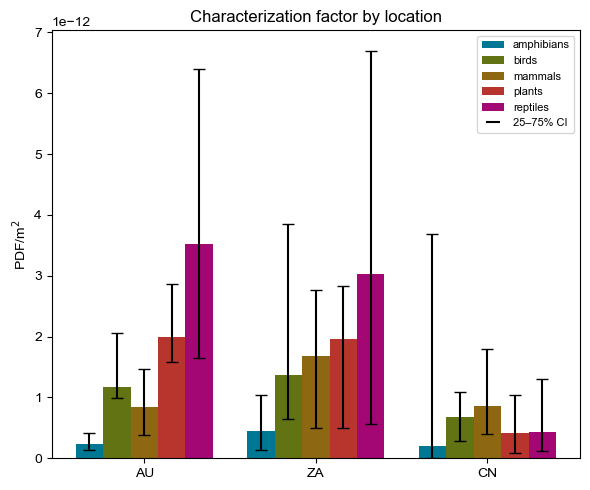

In [27]:
# --- User Configuration ---
custom_colors = ["#007894", "#627313", "#8e6713", "#b7352d", "#a30774"] 

# --- Style Settings ---
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'font.size': 10
})

cutoff = 0.00

# --- Legend Helper ---
errorbar_legend = Line2D(
    [0], [0], color='black', linestyle='none', marker='_',
    markersize=10, markeredgewidth=1.5, label='25–75% CI'
)

# --- Shared Data Prep ---
df_table = main_df_tra_new.copy()
m = df_table.loc[df_table["impact (mean)"] > 0, "impact (mean)"].max()
df = df_table[df_table["impact (mean)"].abs() > cutoff * m].copy()
df_net = df.copy()

# Flags
lower_percentile = "(25th)"
top_percentile = "(75th)"
has_cf_percentiles = f"CF {lower_percentile}" in df.columns and f"CF {top_percentile}" in df.columns

# Calculate Location Order (Standard Top 5)
d = df_net.groupby("consumer location").sum(numeric_only=True)
d = d.sort_values(by="amount", ascending=False)
loc_order = ['AU', 'ZA', 'CN']

# =========================================================
# PLOT B: Characterization factor by location
# =========================================================
fig, ax_b = plt.subplots(figsize=(6, 5)) 

df_b = main_df_tra_new.copy()

# Pick available CF columns
cf_cols = ["CF (mean)", f"CF {lower_percentile}", "CF (50th)", f"CF {top_percentile}"]
cf_cols = [c for c in cf_cols if c in df_b.columns]

# Aggregate
gb_b = (
    df_b
    .groupby(["consumer location", "method"])[cf_cols]
    .mean(numeric_only=True)
    .reset_index()
)

# Restrict to the customized loc_order
gb_b = gb_b[gb_b["consumer location"].isin(loc_order)]
gb_b["consumer location"] = pd.Categorical(gb_b["consumer location"], categories=loc_order, ordered=True)
gb_b = gb_b.sort_values(["consumer location", "method"])

methods_b = list(gb_b["method"].unique())
n_methods_b = max(1, len(methods_b))
x = np.arange(len(loc_order))
bar_width = min(0.8 / n_methods_b, 0.25)

b_dict = {m: gb_b[gb_b["method"] == m].set_index("consumer location") for m in methods_b}

for i, meth in enumerate(methods_b):
    # This .reindex(loc_order) ensures we try to grab 'AU' data specifically
    vals = b_dict[meth].reindex(loc_order)
    y = vals["CF (50th)"].values

    if has_cf_percentiles:
        lower = y - vals[f"CF {lower_percentile}"].values
        upper = vals[f"CF {top_percentile}"].values - y
        cf_errors = np.clip(np.vstack([lower, upper]), 0, None)
    else:
        cf_errors = None

    positions = x - (n_methods_b - 1) * bar_width / 2 + i * bar_width
    
    # Custom colors
    bar_color = custom_colors[i % len(custom_colors)]
    
    ax_b.bar(positions, y, yerr=cf_errors, capsize=4, width=bar_width, 
             label=str(meth), color=bar_color)

ax_b.set_title("Characterization factor by location")
ax_b.set_ylabel("PDF/m$^2$")
ax_b.set_xticks(x)
ax_b.set_xticklabels(loc_order, rotation=0)

# Legend
handles_b, labels_b = ax_b.get_legend_handles_labels()
handles_b.append(errorbar_legend)
labels_b.append('25–75% CI')
ax_b.legend(handles=handles_b, labels=labels_b, loc='upper right', fontsize=8)

plt.tight_layout()
plt.savefig("plots/transformation_CFs_by_location_new.png", dpi=150)
plt.show()

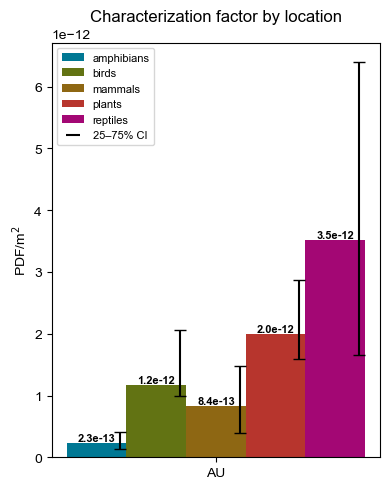

In [39]:
### only AU ###
custom_colors = ["#007894", "#627313", "#8e6713", "#b7352d", "#a30774"] 

# --- Style Settings ---
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'font.size': 10
})

cutoff = 0.00

# --- Legend Helper ---
errorbar_legend = Line2D(
    [0], [0], color='black', linestyle='none', marker='_',
    markersize=10, markeredgewidth=1.5, label='25–75% CI'
)

# --- Shared Data Prep ---
df_table = main_df_tra_new.copy()
m = df_table.loc[df_table["impact (mean)"] > 0, "impact (mean)"].max()
df = df_table[df_table["impact (mean)"].abs() > cutoff * m].copy()
df_net = df.copy()

# Flags
lower_percentile = "(25th)"
top_percentile = "(75th)"
has_cf_percentiles = f"CF {lower_percentile}" in df.columns and f"CF {top_percentile}" in df.columns

# --- CHANGE: Set Location Order to ONLY AU ---
loc_order = ['AU']

# =========================================================
# PLOT B: Characterization factor by location (AU Only)
# =========================================================
fig, ax_b = plt.subplots(figsize=(4, 5)) 

df_b = main_df_tra_new.copy()

# Pick available CF columns
cf_cols = ["CF (mean)", f"CF {lower_percentile}", "CF (50th)", f"CF {top_percentile}"]
cf_cols = [c for c in cf_cols if c in df_b.columns]

# Aggregate
gb_b = (
    df_b
    .groupby(["consumer location", "method"])[cf_cols]
    .mean(numeric_only=True)
    .reset_index()
)

gb_b = gb_b[gb_b["consumer location"].isin(loc_order)]
gb_b["consumer location"] = pd.Categorical(gb_b["consumer location"], categories=loc_order, ordered=True)
gb_b = gb_b.sort_values(["consumer location", "method"])

methods_b = list(gb_b["method"].unique())
n_methods_b = max(1, len(methods_b))
x = np.arange(len(loc_order))
bar_width = min(0.8 / n_methods_b, 0.25)

b_dict = {m: gb_b[gb_b["method"] == m].set_index("consumer location") for m in methods_b}

for i, meth in enumerate(methods_b):
    vals = b_dict[meth].reindex(loc_order)
    y = vals["CF (50th)"].values

    if has_cf_percentiles:
        lower = y - vals[f"CF {lower_percentile}"].values
        upper = vals[f"CF {top_percentile}"].values - y
        cf_errors = np.clip(np.vstack([lower, upper]), 0, None)
    else:
        cf_errors = None

    positions = x - (n_methods_b - 1) * bar_width / 2 + i * bar_width
    
    # Custom colors
    bar_color = custom_colors[i % len(custom_colors)]
    
    # 1. Plot the MAIN BAR (No error bars here)
    bars = ax_b.bar(positions, y, width=bar_width, 
             label=str(meth), color=bar_color)

    # 2. Plot the ERROR BAR manually at the right edge
    if has_cf_percentiles:
        # Calculate X position: Center + Half Width = Right Edge
        error_x = positions + (bar_width / 2.5)
        
        ax_b.errorbar(error_x, y, yerr=cf_errors, 
                      fmt='none',       # 'none' means don't plot a marker point
                      ecolor='black',   # Color of the error line
                      elinewidth=1.5,   # Thickness of line
                      capsize=4)        # Width of the horizontal caps

    # 3. Add Labels (Centered on the bar)
    for bar, val in zip(bars, y):
        if pd.isna(val): continue
        y_pos = bar.get_height()
        ax_b.text(
            bar.get_x() + bar.get_width() / 2,  
            y_pos,                              
            f"{val:.1e}",                       
            ha='center', va='bottom', fontsize=8, color='black', fontweight='bold'
        )

ax_b.set_title("Characterization factor by location")
ax_b.set_ylabel("PDF/m$^2$")
ax_b.set_xticks(x)
ax_b.set_xticklabels(loc_order, rotation=0)

# Legend
handles_b, labels_b = ax_b.get_legend_handles_labels()
handles_b.append(errorbar_legend)
labels_b.append('25–75% CI')
ax_b.legend(handles=handles_b, labels=labels_b, loc='upper left', fontsize=8)

plt.tight_layout()
plt.savefig("plots/transformation_CFs_by_location_AU_new.png", dpi=150)
plt.show()

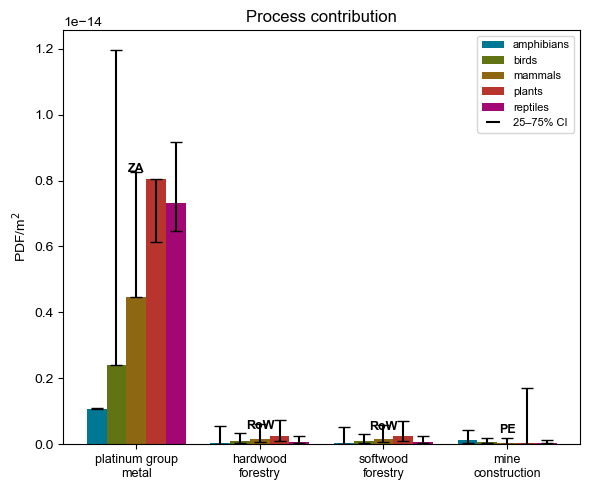

In [28]:
# --- User Configuration ---
# REPLACE THESE WITH YOUR EXACT HEX CODES
# Ensure you have as many colors as you have methods
custom_colors = ["#007894", "#627313", "#8e6713", "#b7352d", "#a30774"]

# --- Style Settings ---
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'font.size': 10
})

# --- Legend Helper ---
errorbar_legend = Line2D(
    [0], [0], color='black', linestyle='none', marker='_',
    markersize=10, markeredgewidth=1.5, label='25–75% CI'
)

# =========================================================
# PLOT C: Process contribution
# =========================================================
fig, ax_c = plt.subplots(figsize=(6, 5))

# --- Data Prep ---
df_c = main_df_tra_new.copy()
df_c["consumer name"] = df_c["consumer name"].str.split(", ").str[0]
df_c["label"] = df_c["consumer name"] + " (" + df_c["consumer location"] + ")"

# Flags
lower_percentile = "(25th)"
top_percentile = "(75th)"
has_imp_percentiles = f"impact {lower_percentile}" in df_c.columns and f"impact {top_percentile}" in df_c.columns

# Select top 4 labels by total mean impact
top_labels = (df_c.groupby("label", as_index=False)["impact (50th)"]
                .sum(numeric_only=True)
                .sort_values("impact (50th)", ascending=False)
                .head(4)["label"]
                .tolist())

# Aggregation dict
agg_c = {"impact (50th)": "sum"}
if has_imp_percentiles:
    agg_c[f"impact {lower_percentile}"] = "sum"
    agg_c[f"impact {top_percentile}"] = "sum"

# Group and aggregate
gb_c = (df_c[df_c["label"].isin(top_labels)]
        .groupby(["label", "method"])
        .agg(agg_c)
        .reset_index())

gb_c["label"] = pd.Categorical(gb_c["label"], categories=top_labels, ordered=True)
gb_c = gb_c.sort_values(["label", "method"])

methods_c = list(gb_c["method"].unique())
n_methods_c = max(1, len(methods_c))
x_c = np.arange(len(top_labels))
bar_width_c = min(0.8 / n_methods_c, 0.25)

# Per-method lookup
c_dict = {m: gb_c[gb_c["method"] == m].set_index("label") for m in methods_c}

# --- Plotting Loop ---
for i, meth in enumerate(methods_c):
    vals = c_dict[meth].reindex(top_labels)
    y = vals["impact (50th)"].values

    if has_imp_percentiles:
        err_lower = y - vals.get(f"impact {lower_percentile}", pd.Series(index=vals.index, dtype=float)).values
        err_upper = vals.get(f"impact {top_percentile}", pd.Series(index=vals.index, dtype=float)).values - y
        errors = np.clip(np.vstack([err_lower, err_upper]), 0, None)
    else:
        errors = None

    positions = x_c - (n_methods_c - 1) * bar_width_c / 2 + i * bar_width_c
    
    # --- COLOR SELECTION LOGIC ---
    bar_color = custom_colors[i % len(custom_colors)]

    ax_c.bar(positions, y, yerr=errors, capsize=4, width=bar_width_c, 
             label=str(meth), color=bar_color)

# --- Formatting ---
short_labels = pd.Series(top_labels).str.replace(r" \(([^)]+)\)$", "", regex=True)
countries = pd.Series(top_labels).str.extract(r"\(([^)]+)\)$")[0]
short_labels = [lbl.rsplit(" ", 1)[0] + "\n" + lbl.rsplit(" ", 1)[1] if " " in lbl else lbl
                for lbl in short_labels]
short_labels = [lbl.replace("deionized", "").replace("gravel and sand ", "") for lbl in short_labels]

ax_c.set_xticks(x_c)
ax_c.set_xticklabels(short_labels, rotation=0, ha="center", size=9)
ax_c.set_title("Process contribution")
ax_c.set_ylabel("PDF/m$^2$")

# Annotate Country Codes
cluster_tops = []
for j in range(len(x_c)):
    ys = []
    for meth in methods_c:
        vals = c_dict[meth].reindex(top_labels)
        ys.append(vals["impact (50th)"].values[j] if j < len(vals) else np.nan)
    cluster_tops.append(np.nanmax(ys))

for xi, yi, code in zip(x_c, cluster_tops, countries):
    if pd.notna(yi):
        ax_c.annotate(code, (xi, yi), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=9, fontweight='bold')

# Legend
handles_c, labels_c = ax_c.get_legend_handles_labels()
handles_c.append(errorbar_legend)
labels_c.append('25–75% CI')
ax_c.legend(handles=handles_c, labels=labels_c, loc='upper right', fontsize=8)

plt.tight_layout()
plt.savefig("plots/transformation_CFs_by_process_new.png", dpi=150)
plt.show()